# QM9 training example

This notebook contains an end-to-end example to train a GAN model on a specific set of molecules and visualize the generated structures. It uses molecules from the QM9 database as training examples and NeuralIL's descriptor generator method.  

If you do not have enough compute available, please check the "QM9 filter example" to use an already trained model.

In [1]:
from structgan.model import Generator, Critic
from structgan.training import *
from structgan.utils import *
from neuralil.bessel_descriptors import PowerSpectrumGenerator

import optax
import flax.linen as nn

import jax
import jax.numpy as jnp
import numpy as np

from ase import Atoms
from ase.visualize import view
import matplotlib.pyplot as plt

import pickle

We generate rattled versions of all C4H10O and C6H14O isomers as training data.

In [2]:
allatoms = pickle.load(open("QM9_data/train_atoms.pck", "rb"))

N_RATTLE = 20
RATTLESIZE = 0.05

train_formulas = ["C4H10O", "C6H14O"]

train_atoms = []
for atoms in allatoms:
    if atoms.get_chemical_formula() in train_formulas:
        for i in range(N_RATTLE):
            tmp = atoms.copy()
            tmp.rattle(RATTLESIZE)
            train_atoms.append(tmp)

anum_map = make_atomic_number_map(train_atoms)
N_TYPES = len(anum_map)
reverse_anum_map = {}
for elem in anum_map:
    reverse_anum_map[anum_map[elem]] = elem

As descriptors we use the per atom flattened version of NeuralIL's descriptors extended with a one-hot encoding of the atom type.

In [3]:
R_CUT = 5
N_MAX = 4
N_NEIG = 10
descriptor_generator = PowerSpectrumGenerator(N_MAX, R_CUT, N_TYPES, N_NEIG)


@jax.jit
def desc_generator_method(allpos, alltype, pos, types, cell):
    desc = descriptor_generator.process_some_data(allpos, alltype, pos, cell)
    desc = jnp.reshape(desc, (pos.shape[0], -1))
    desc = jnp.append(desc, jax.nn.one_hot(types, N_TYPES), axis=1)

    return desc


training_dict = make_training_dict(train_atoms, desc_generator_method, anum_map)

Define the necessary parameters of the generator and critic models.  
Since the generator (with the postprocessing) generates the atoms in a cell, it has to be specified to a realistic size.  If the cell is too small we are unable to generate realistic structures, if it is too large the training becomes unstable, since if atoms are spread out more than R_CUT far away from eachother the generator gets no gradient information during the training.

The postprocessing step returns with ```np.zeros((3,3))``` unit cell, since that is used to turn off the PBC in the descriptor generation.

In [4]:
SEED = 333
rng = jax.random.PRNGKey(SEED)

N_DIMENSIONS = 3
N_LATENT = 20
TYPES = np.array([6] * 5 + [1] * 12 + [8])
TYPES = np.array([anum_map[t] for t in TYPES])
N_POINTS = len(TYPES)
GEN_CELL = jnp.array([[8.0, 0.0, 0.0], [0.0, 7.0, 0.0], [0.0, 0.0, 6.0]])

GENERATOR_SHAPE = [512, 256, 128, 64, 32]
CRITIC_SHAPE = [256, 128, 64, 32]

N_BATCH = 15
N_CRIT = 5
N_GP_PER_CRIT = 2

LR_CRIT = 10**-3.5
LR_GEN = 10**-3.5


def postprocess(intermediate):
    pos = intermediate.reshape((N_POINTS, N_DIMENSIONS))
    pos = jnp.matmul(pos, GEN_CELL)
    return pos, TYPES, pos, TYPES, jnp.zeros(shape=(3, 3))

In [5]:
generator = Generator(
    features=GENERATOR_SHAPE,
    n_points=N_POINTS,
    n_dimensions=N_DIMENSIONS,
    n_latent=N_LATENT,
    n_scalars=0,
)

critic = Critic(features=CRITIC_SHAPE)

optimizer_gen = optax.rmsprop(LR_GEN)
optimizer_crit = optax.rmsprop(LR_CRIT)

In [6]:
rng, key = jax.random.split(rng)
params_gen = generator.init(key, jax.random.normal(key, shape=(N_LATENT,)))
rng, key = jax.random.split(rng)
params_crit = critic.init(key, training_dict[0][0])

opt_state_gen = optimizer_gen.init(params_gen)
opt_state_crit = optimizer_crit.init(params_crit)

Define the full training step.

In [7]:
train_step = jax.jit(create_full_training_step(
    critic,
    generator,
    desc_generator_method,
    postprocess,
    TYPES,
    training_dict,
    optimizer_crit,
    optimizer_gen,
    N_BATCH,
    N_CRIT,
    N_GP_PER_CRIT,
))

Utility functions to hide explicit dependence on the critic, postprocessing, etc...

In [8]:
generate_single_desc = create_generate_descriptor(desc_generator_method)
generate_batch_desc = create_generate_batch_descriptor(desc_generator_method)

generate_structures = create_generate_structures(generator, postprocess, N_LATENT)

In [9]:
sampler = make_real_sampler(TYPES, N_BATCH, training_dict)

In [10]:
real_preds = []
fake_preds = []
gen_snapshots = []
crit_snapshots = []

Start the training. Snapshots are taken every 100 iteration.

For reasonable results longer training is needed, this is here only for illustration.

In [11]:
for i in range(60*100+1):
    if i % 100 == 0:
        rng, key = jax.random.split(rng)
        allpos, alltype, pos, types, cell = generate_structures(params_gen, key, N_BATCH)
        desc = generate_batch_desc(allpos, alltype, pos, types, cell)
        desc = desc.reshape((-1, desc.shape[-1]))

        pred_fake = np.mean(critic.apply(params_crit, desc))
        real_desc, rng = sampler(rng)
        real_desc = real_desc.reshape((N_BATCH * N_POINTS, -1))
        pred_real = np.mean(critic.apply(params_crit, real_desc))

        real_preds.append(pred_real)
        fake_preds.append(pred_fake)

        print(i, pred_fake, pred_real, pred_fake - pred_real)

        gen_snapshots.append(params_gen)
        crit_snapshots.append(params_crit)

    params_gen, opt_state_gen, params_crit, opt_state_crit,  rng = train_step(
        params_gen, opt_state_gen, params_crit, opt_state_crit,  rng
    )

0 0.081985295 -0.0035331843 0.08551848
100 0.0930789 -0.16690068 0.25997958
200 0.075934656 -0.15331897 0.22925362
300 0.12711672 -0.11126638 0.23838311
400 0.044792775 -0.18337967 0.22817244
500 0.069196686 -0.13345256 0.20264925
600 0.07242584 -0.13969381 0.21211965
700 0.15134059 -0.09647217 0.24781275
800 0.089222506 -0.14198878 0.23121129
900 0.099139854 -0.12552652 0.22466637
1000 0.11673446 -0.11952774 0.2362622
1100 0.1177598 -0.101770334 0.21953014
1200 0.12770307 -0.07845226 0.20615533
1300 0.14151767 -0.06955593 0.2110736
1400 0.17258 -0.052000057 0.22458006
1500 0.13368376 -0.07924605 0.21292982
1600 0.14832877 -0.05250682 0.20083559
1700 0.11568456 -0.08175281 0.19743738
1800 0.13634233 -0.07409128 0.2104336
1900 0.20651715 -0.012095471 0.21861261
2000 0.17026477 -0.03058743 0.2008522
2100 0.17909196 -0.02772662 0.20681858
2200 0.17029783 -0.032013185 0.20231101
2300 0.1515821 -0.035207495 0.1867896
2400 0.15097897 -0.03191341 0.18289238
2500 0.15155956 -0.045331813 0.1968

Text(0.5, 0, 'Epoch')

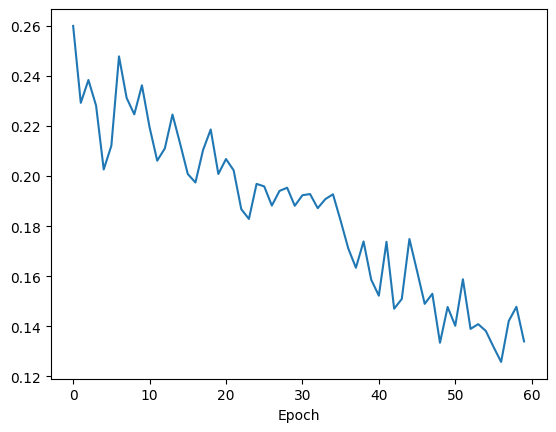

In [12]:
plt.plot(np.array(fake_preds)[1:] - np.array(real_preds)[1:])
plt.xlabel("Epoch")

Generate and visualize a structure. Rerunning the cell can result in different structures.

In [13]:
rng, key = jax.random.split(rng)
all_pos, all_type, _, _, _ = generate_structures(params_gen, key, 1)
atom = Atoms(positions=all_pos[0])
atom.center(about=0)
atom.set_atomic_numbers(
    np.array([reverse_anum_map[int(i)] for i in all_type[0]]).flatten()
)
view(atom, viewer="x3d")

: 

: 